## Week 2: Dataset Acquisition and Preprocessing 

In [50]:
#install the libraries: 
### pytorch for python3.12

# brew install python@3.12
# python3.11 --version
# python3.11 -m venv venv
# source myenv/bin/activate
# pip install torch torchvision torchaudio

#verify the intallation 


In [1]:
import torch

In [2]:
print(torch.__version__)

2.6.0


In [53]:
# download the dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia 

In [3]:
#import the libraries 
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # always come together
import numpy as np

In [4]:
#upload the data
data_train = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train"
data_test = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/test"
data_val = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val"


In [5]:
# Define the transformations with data augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [6]:
# How many images are in each folder for each class? 

import os

# Define the directories
data_dirs = {
    "Train": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train",
    "Test": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/test",
    "Validation": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val",
}

# Count the number of images in each subfolder (PNEUMONIA, NORMAL)
for category, path in data_dirs.items():
    print(f"\n{category} Set:")
    
    for class_name in ["PNEUMONIA", "NORMAL"]:  # Check specific folders
        class_path = os.path.join(path, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"  - {class_name}: {num_images} images")
        else:
            print(f"  - {class_name}: Folder not found")



Train Set:
  - PNEUMONIA: 3875 images
  - NORMAL: 1341 images

Test Set:
  - PNEUMONIA: 390 images
  - NORMAL: 234 images

Validation Set:
  - PNEUMONIA: 8 images
  - NORMAL: 8 images


Train Set:
  - PNEUMONIA: 3875 images
  - NORMAL: 1341 images

Test Set:
  - PNEUMONIA: 390 images
  - NORMAL: 234 images

Validation Set:
  - PNEUMONIA: 8 images
  - NORMAL: 8 images

# Adressing imbalance of the data in training set: 
imbalance would create an overfit toward the majority class
solutions:
1) downsample the majority class: downside - loss of information
2) oversample the minority class: 
3) class weight in loss function: modifies the loss function to assign a higher penalty to misclassifications of the minority class. 
        - should be done at the later stage.
        

In [7]:
# My choice is oversampling the minority class:
 
#load the libs
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import os
import random
from PIL import Image

# Load dataset (not yet transformed)
dataset = datasets.ImageFolder(root=data_train, transform=transform_train)


# Get class indices
class_indices = dataset.class_to_idx  # {'NORMAL': 0, 'PNEUMONIA': 1}
normal_idx = class_indices['NORMAL']
pneumonia_idx = class_indices['PNEUMONIA']

# Separate NORMAL and PNEUMONIA images
normal_images = [img_path for img_path, label in dataset.samples if label == normal_idx]
pneumonia_images = [img_path for img_path, label in dataset.samples if label == pneumonia_idx]

# Count images per class
num_normal = len(normal_images)
num_pneumonia = len(pneumonia_images)

print(f"Original count: NORMAL = {num_normal}, PNEUMONIA = {num_pneumonia}")


Original count: NORMAL = 1341, PNEUMONIA = 3875


In [8]:
# Oversample NORMAL images by randomly duplicating them
oversampled_normal_images = normal_images * (num_pneumonia // num_normal)  # Duplicate fully
oversampled_normal_images += random.sample(normal_images, num_pneumonia - len(oversampled_normal_images))  # Add remaining

In [9]:
# create the dataset for the train set(normal oversampled + pneumonia)

class OversampledDataset(Dataset):
    def __init__(self, normal_images, pneumonia_images, transform=None):
        self.image_paths = normal_images + pneumonia_images  # Merge both classes
        self.labels = [0] * len(normal_images) + [1] * len(pneumonia_images)  # Assign labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("L")  # 'L' mode is for grayscale (1 channel)
        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Create dataset
balanced_dataset = OversampledDataset(oversampled_normal_images, pneumonia_images, transform_train)

# Create DataLoader
train_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

# Verify batch distribution
num_normal_batch = sum(1 for _, labels in train_loader for label in labels if label == 0)
num_pneumonia_batch = sum(1 for _, labels in train_loader for label in labels if label == 1)

print(f"After Oversampling: NORMAL = {num_normal_batch}, PNEUMONIA = {num_pneumonia_batch}")


After Oversampling: NORMAL = 3875, PNEUMONIA = 3875


## Visualise a sample after preprocessing

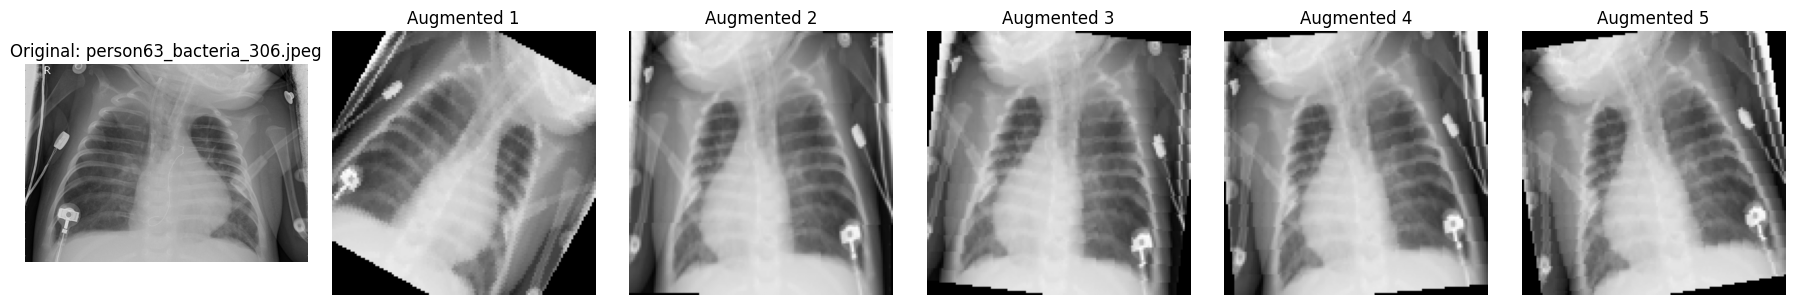

In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Path to a sample image in your dataset
img_path = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train/PNEUMONIA"
sample_img = os.listdir(img_path)[0]  # Get the first image in the directory

# Load the image
image = Image.open(os.path.join(img_path, sample_img))

# Convert to grayscale explicitly before applying transformations
image = image.convert('L')  # 'L' mode is for grayscale

# Define grayscale-compatible transformations (e.g., without color jitter)


# Apply the transformations to the image
augmented_images = [transform_train(image) for _ in range(5)]  # Apply the transformation 5 times to generate 5 augmented images

# Plot the original and augmented images
fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # 6 subplots: 1 for the original and 5 for augmented images
axes[0].imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
axes[0].set_title(f"Original: {sample_img}")  # Display the original image name
axes[0].axis('off')  # Hide axis

for i, aug_img in enumerate(augmented_images):
    axes[i + 1].imshow(aug_img.permute(1, 2, 0), cmap='gray')  # Convert from CHW to HWC and apply 'gray' colormap
    axes[i + 1].set_title(f"Augmented {i + 1}")
    axes[i + 1].axis('off')  # Hide axis

plt.tight_layout()
plt.show()


In [11]:
# create data loader: 
val_dataset = datasets.ImageFolder(data_val, transform=transform_val)
test_dataset = datasets.ImageFolder(data_test, transform=transform_val)

# Create data loaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Week 3: Model Development
- Design a CNN architecture tailored for image classification.
- Train the model on the dataset with proper validation.
- Evaluate the model's performance using metrics like accuracy, precision, recall, and F1-score.
- Fine-tune the model for optimal performance.

In [12]:
# Define the model
import torch
import torch.nn as nn

class CNNClassifierGrayscale(nn.Module):
    def __init__(self):
        super(CNNClassifierGrayscale, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust based on the image size
        self.fc2 = nn.Linear(512, 2)  # For 2 classes

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with ReLU and dropout
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        
        # Output layer (Softmax for multi-class classification)
        x = self.fc2(x)
        return x


In [13]:
#set the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

# Initialize model
model = CNNClassifierGrayscale().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

num_epochs = 21
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for inputs, labels in tqdm(train_loader):  # Add progress bar
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights

        running_loss += loss.item() * inputs.size(0)

        # Store predictions and true labels for metric calculation
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate loss, accuracy, precision, recall, and F1 score for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_recall = recall_score(all_labels, all_preds, average='macro')
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Loss: {epoch_loss:.4f}')
    print(f'  Accuracy: {epoch_accuracy:.4f}')
    print(f'  Precision: {epoch_precision:.4f}')
    print(f'  Recall: {epoch_recall:.4f}')
    print(f'  F1 Score: {epoch_f1:.4f}')


100%|██████████| 243/243 [02:09<00:00,  1.87it/s]


Epoch [1/21]
  Loss: 0.1914
  Accuracy: 0.9272
  Precision: 0.9272
  Recall: 0.9272
  F1 Score: 0.9272


100%|██████████| 243/243 [02:11<00:00,  1.85it/s]


Epoch [2/21]
  Loss: 0.1547
  Accuracy: 0.9417
  Precision: 0.9417
  Recall: 0.9417
  F1 Score: 0.9417


100%|██████████| 243/243 [02:11<00:00,  1.84it/s]


Epoch [3/21]
  Loss: 0.1346
  Accuracy: 0.9507
  Precision: 0.9507
  Recall: 0.9507
  F1 Score: 0.9507


100%|██████████| 243/243 [02:10<00:00,  1.86it/s]


Epoch [4/21]
  Loss: 0.1230
  Accuracy: 0.9523
  Precision: 0.9523
  Recall: 0.9523
  F1 Score: 0.9523


100%|██████████| 243/243 [02:10<00:00,  1.86it/s]


Epoch [5/21]
  Loss: 0.1123
  Accuracy: 0.9591
  Precision: 0.9591
  Recall: 0.9591
  F1 Score: 0.9591


100%|██████████| 243/243 [02:10<00:00,  1.86it/s]


Epoch [6/21]
  Loss: 0.1019
  Accuracy: 0.9619
  Precision: 0.9619
  Recall: 0.9619
  F1 Score: 0.9619


100%|██████████| 243/243 [02:09<00:00,  1.87it/s]


Epoch [7/21]
  Loss: 0.1001
  Accuracy: 0.9628
  Precision: 0.9628
  Recall: 0.9628
  F1 Score: 0.9628


100%|██████████| 243/243 [02:10<00:00,  1.87it/s]


Epoch [8/21]
  Loss: 0.0975
  Accuracy: 0.9636
  Precision: 0.9636
  Recall: 0.9636
  F1 Score: 0.9636


100%|██████████| 243/243 [02:10<00:00,  1.86it/s]


Epoch [9/21]
  Loss: 0.0970
  Accuracy: 0.9643
  Precision: 0.9643
  Recall: 0.9643
  F1 Score: 0.9643


100%|██████████| 243/243 [02:10<00:00,  1.87it/s]


Epoch [10/21]
  Loss: 0.0885
  Accuracy: 0.9685
  Precision: 0.9685
  Recall: 0.9685
  F1 Score: 0.9685


100%|██████████| 243/243 [02:09<00:00,  1.87it/s]


Epoch [11/21]
  Loss: 0.0826
  Accuracy: 0.9699
  Precision: 0.9699
  Recall: 0.9699
  F1 Score: 0.9699


100%|██████████| 243/243 [02:10<00:00,  1.86it/s]


Epoch [12/21]
  Loss: 0.0820
  Accuracy: 0.9703
  Precision: 0.9703
  Recall: 0.9703
  F1 Score: 0.9703


100%|██████████| 243/243 [02:11<00:00,  1.85it/s]


Epoch [13/21]
  Loss: 0.0772
  Accuracy: 0.9724
  Precision: 0.9724
  Recall: 0.9724
  F1 Score: 0.9724


100%|██████████| 243/243 [02:09<00:00,  1.87it/s]


Epoch [14/21]
  Loss: 0.0711
  Accuracy: 0.9738
  Precision: 0.9738
  Recall: 0.9738
  F1 Score: 0.9738


100%|██████████| 243/243 [02:09<00:00,  1.88it/s]


Epoch [15/21]
  Loss: 0.0714
  Accuracy: 0.9742
  Precision: 0.9742
  Recall: 0.9742
  F1 Score: 0.9742


100%|██████████| 243/243 [02:10<00:00,  1.87it/s]


Epoch [16/21]
  Loss: 0.0633
  Accuracy: 0.9760
  Precision: 0.9760
  Recall: 0.9760
  F1 Score: 0.9760


100%|██████████| 243/243 [02:11<00:00,  1.85it/s]


Epoch [17/21]
  Loss: 0.0709
  Accuracy: 0.9743
  Precision: 0.9743
  Recall: 0.9743
  F1 Score: 0.9743


100%|██████████| 243/243 [02:11<00:00,  1.85it/s]


Epoch [18/21]
  Loss: 0.0714
  Accuracy: 0.9717
  Precision: 0.9718
  Recall: 0.9717
  F1 Score: 0.9717


100%|██████████| 243/243 [02:11<00:00,  1.84it/s]


Epoch [19/21]
  Loss: 0.0641
  Accuracy: 0.9765
  Precision: 0.9765
  Recall: 0.9765
  F1 Score: 0.9765


100%|██████████| 243/243 [02:10<00:00,  1.86it/s]


Epoch [20/21]
  Loss: 0.0622
  Accuracy: 0.9773
  Precision: 0.9773
  Recall: 0.9773
  F1 Score: 0.9773


100%|██████████| 243/243 [02:24<00:00,  1.68it/s]

Epoch [21/21]
  Loss: 0.0594
  Accuracy: 0.9763
  Precision: 0.9763
  Recall: 0.9763
  F1 Score: 0.9763


## Evaluation 

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Switch model to evaluation mode
model.eval()

# Track predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():  # No need to track gradients for evaluation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9375
Precision: 0.9444
Recall: 0.9375
F1 Score: 0.9373


Precision, Recall, F1-Score: These metrics provide a deeper understanding of model performance, especially in imbalanced datasets where accuracy might be misleading.

## Fine tuning the hyperparameters

1. Adjusting the learning rate for the optimizer.
2. Adding regularization such as dropout or L2 regularization.
3. Using data augmentation to prevent overfitting.
4. Early stopping to prevent training for too long and avoid overfitting.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import torch
from torchvision import transforms

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Data augmentation for better generalization
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Early stopping parameters
patience = 2
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Training loop
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Track predictions and labels
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_recall = recall_score(all_labels, all_preds, average='macro')
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Training Loss: {epoch_loss:.4f}')
    print(f'  Training Accuracy: {epoch_accuracy:.4f}')
    print(f'  Training Precision: {epoch_precision:.4f}')
    print(f'  Training Recall: {epoch_recall:.4f}')
    print(f'  Training F1 Score: {epoch_f1:.4f}')
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Track validation predictions and labels
            _, predicted = torch.max(outputs.data, 1)
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds, average='macro')
    val_recall = recall_score(all_val_labels, all_val_preds, average='macro')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}')

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break
    
    # Step the learning rate scheduler
    scheduler.step()


100%|██████████| 243/243 [02:16<00:00,  1.78it/s]
/Users/cholponzhakshylykova/Desktop/SDS/SDS-CP021-pneumonia-detection/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [1/5]
  Training Loss: 0.0679
  Training Accuracy: 0.9750
  Training Precision: 0.9750
  Training Recall: 0.9750
  Training F1 Score: 0.9750
Validation Loss: 0.1895
Validation Accuracy: 0.9375
Validation Precision: 0.9444
Validation Recall: 0.9375
Validation F1 Score: 0.9373


100%|██████████| 243/243 [02:13<00:00,  1.82it/s]


Epoch [2/5]
  Training Loss: 0.0571
  Training Accuracy: 0.9804
  Training Precision: 0.9804
  Training Recall: 0.9804
  Training F1 Score: 0.9804
Validation Loss: 0.0847
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000


100%|██████████| 243/243 [02:12<00:00,  1.84it/s]


Epoch [3/5]
  Training Loss: 0.0577
  Training Accuracy: 0.9799
  Training Precision: 0.9799
  Training Recall: 0.9799
  Training F1 Score: 0.9799
Validation Loss: 0.1499
Validation Accuracy: 0.9375
Validation Precision: 0.9444
Validation Recall: 0.9375
Validation F1 Score: 0.9373


100%|██████████| 243/243 [02:09<00:00,  1.87it/s]


Epoch [4/5]
  Training Loss: 0.0598
  Training Accuracy: 0.9788
  Training Precision: 0.9788
  Training Recall: 0.9788
  Training F1 Score: 0.9788
Validation Loss: 0.1236
Validation Accuracy: 0.9375
Validation Precision: 0.9444
Validation Recall: 0.9375
Validation F1 Score: 0.9373
Early stopping triggered.


In [20]:
# Test the model on the test data

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Set the model to evaluation mode
model.eval()

# Initialize variables to accumulate test results
test_loss = 0.0
all_test_preds = []
all_test_labels = []

# Ensure no gradient calculations are done during testing (to save memory and computation)
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in tqdm(test_loader):  # assuming `test_loader` is your test data loader
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Get predicted class labels
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels for performance metrics
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate average test loss
test_loss /= len(test_loader.dataset)

# Calculate performance metrics for the test set
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds, average='macro')
test_recall = recall_score(all_test_labels, all_test_preds, average='macro')
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')

# Print results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]

Test Loss: 0.5659
Test Accuracy: 0.8446
Test Precision: 0.8772
Test Recall: 0.8004
Test F1 Score: 0.8189
